# Churn prediction example

## 0. Goal

Churn prediction exercice

## 1. Data Preparation

Let's find out how the dataset is conformed, and if there are missing data, errors or outliers. Then also observe if there are correlations between variables (for later feature selection) or if there are features that might required transformations or normalization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
import src.utils


In [2]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Errors:

mistaken types for TotalCharges, and SeniorCitizen

#### Missing Values:

Apparently none. But errors in types might indicate a missing value. It will be removed in that case.

In [6]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('str')

In [7]:
def parse_or_default(x):
    try:
        return float(x)
    except:
        return -1.0
    
df['TotalCharges'] = df['TotalCharges'].apply(parse_or_default)
mask = df['TotalCharges'] == -1.0
df_missing = df.loc[mask,:]
df = df.loc[~mask,:]
print("There are ",len(df_missing),"missing values, that we will discard")

There are  11 missing values, that we will discard


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [9]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


We removed 11 rows with missing values and corrected the data type of TotalCharges and SeniorCitizen.

#### Outliers:
Let's first look at the distributions of each feature

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
num rows 10 num cols 2  total 20


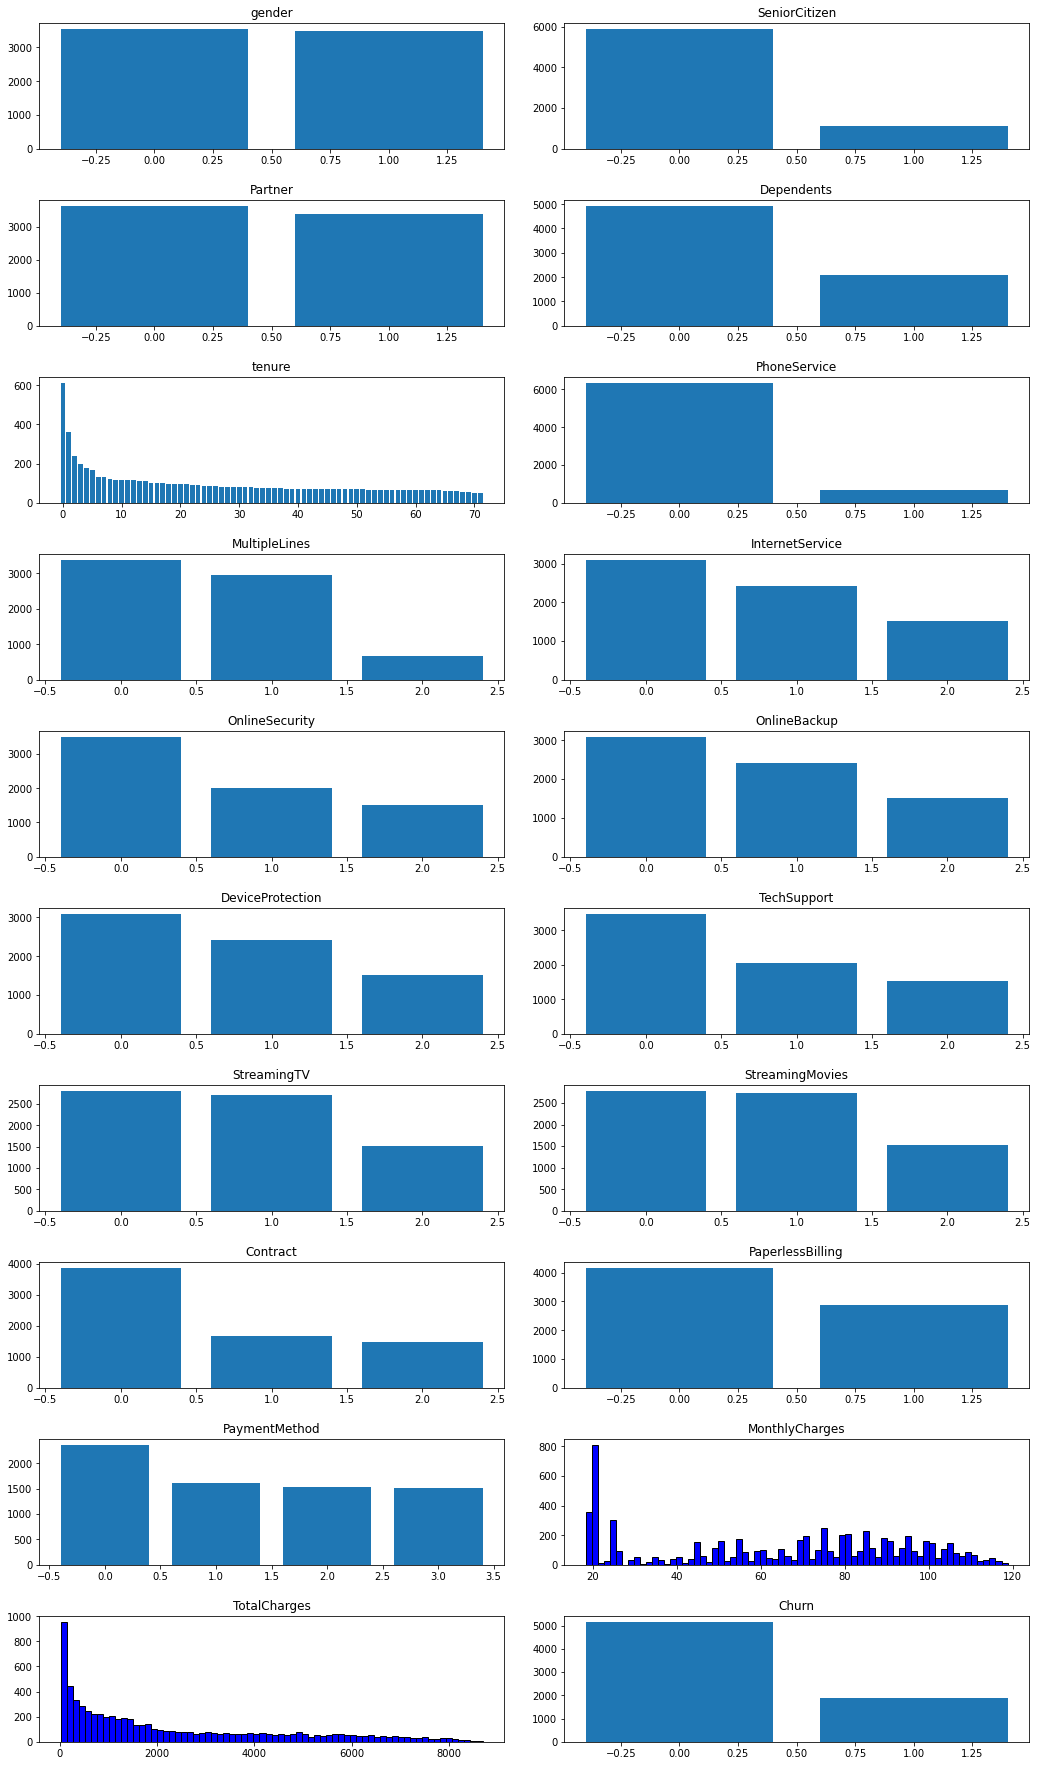

In [11]:

"""
customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 
'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 
'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 
'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
"""
selected_columns = list(df.columns)
selected_columns.pop(selected_columns.index('customerID'))
print(selected_columns)

plot_grid = MyPlotGrid(ncols=2, total_plots=len(selected_columns), figsize=(15,25))
plot_grid_iter = iter(plot_grid)
for column in selected_columns:
    plot_axis = next(plot_grid_iter)
    print_distribution(df,column, plot_axis)

        

##### Outliers
Aparently no univariate outliers are seen on the data

### Correlations
Look at scatter plots to see highly correlated variables (to remove for some machine learning algorithms)

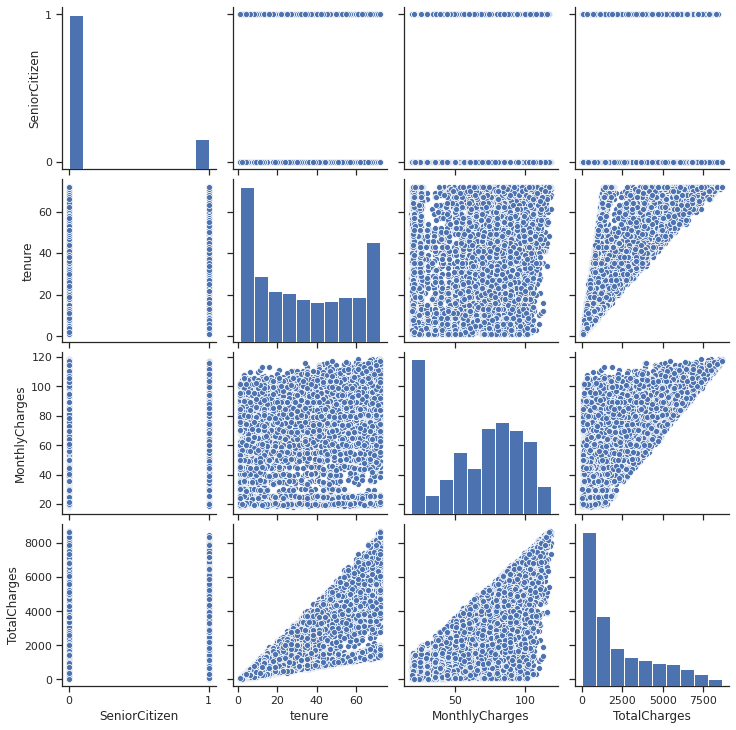

In [12]:
sns.set(style='ticks', color_codes=True)
g = sns.pairplot(data=df)


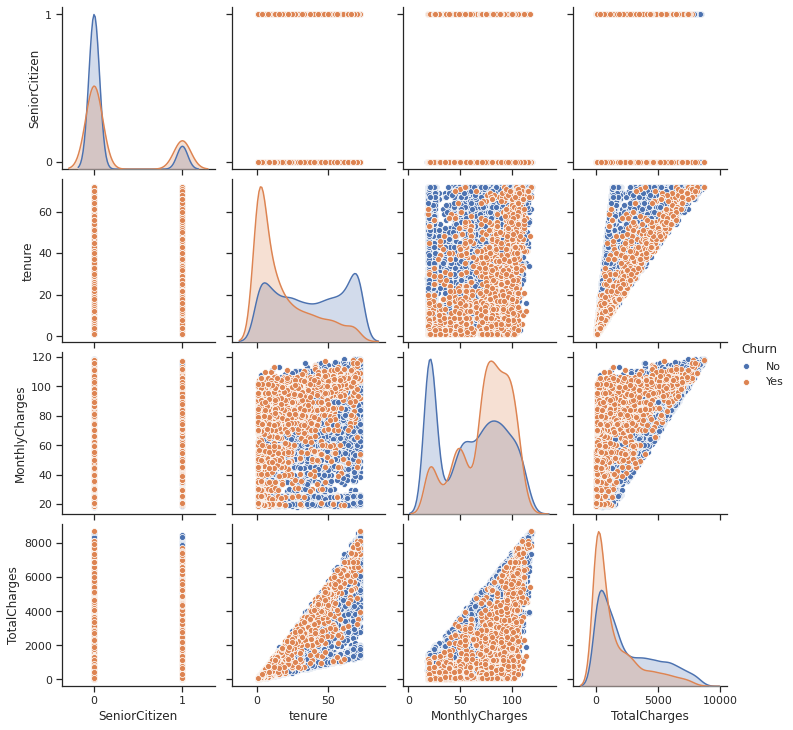

In [13]:
sns.set(style='ticks', color_codes=True)
g = sns.pairplot(data=df, hue="Churn")


###### Correlations
We clearly see that TotalCharges is highly correlated with MonthlyCharges and Tenure. We might consider removeing TotalCharges or keep it and remove MonthlyCharges and tenure.

## Dataset splits

first of all the dataset will be split into training, validation and testing